In [10]:
import geopandas
import pandas as pd
import numpy as np

from tqdm import tqdm
from scipy.spatial import cKDTree

from shapely.geometry import Point, box
from shapely.strtree import STRtree
from shapely.ops import nearest_points

from litecoder.models import WOFLocality

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('seaborn-muted')

In [16]:
rows = []
for loc in WOFLocality.query:
    rows.append((loc.wof_id, loc.name, loc.us_state_abbr, loc.longitude, loc.latitude, loc.population))
    
df = pd.DataFrame(rows, columns=('wof_id', 'name', 'state', 'longitude', 'latitude', 'population'))

In [17]:
df['point'] = list(zip(df.longitude, df.latitude))
df['point'] = df['point'].apply(Point)

In [18]:
gdf = geopandas.GeoDataFrame(df, geometry='point')

In [19]:
gdf.head(10)

,wof_id,name,state,longitude,latitude,population,point
0,85897411,Valley Head,AL,-85.621354,34.557517,558.0,POINT (-85.621354 34.557517)
1,85897417,Sylvania,AL,-85.804804,34.562109,1837.0,POINT (-85.804804 34.562109)
2,85897421,Shiloh,AL,-85.877994,34.463763,274.0,POINT (-85.877994 34.463763)
3,85897425,Rainsville,AL,-85.843520,34.493782,4948.0,POINT (-85.84352 34.493782)
4,85897429,Powell,AL,-85.897879,34.532534,NaN,POINT (-85.897879 34.532534)
5,85897435,Pine Ridge,AL,-85.780673,34.448890,282.0,POINT (-85.78067299999999 34.44889)
6,85897439,Mentone,AL,-85.584222,34.566291,360.0,POINT (-85.584222 34.566291)
7,85897443,Lakeview,AL,-85.975703,34.391629,143.0,POINT (-85.975703 34.391629)
8,85897447,Tuscumbia,AL,-87.703381,34.721209,8423.0,POINT (-87.70338099999999 34.721209)
9,85897453,Geraldine,AL,-86.003706,34.357721,896.0,POINT (-86.00370599999999 34.357721)


In [20]:
gdf.population = gdf.population.fillna(gdf.population.median())

3100


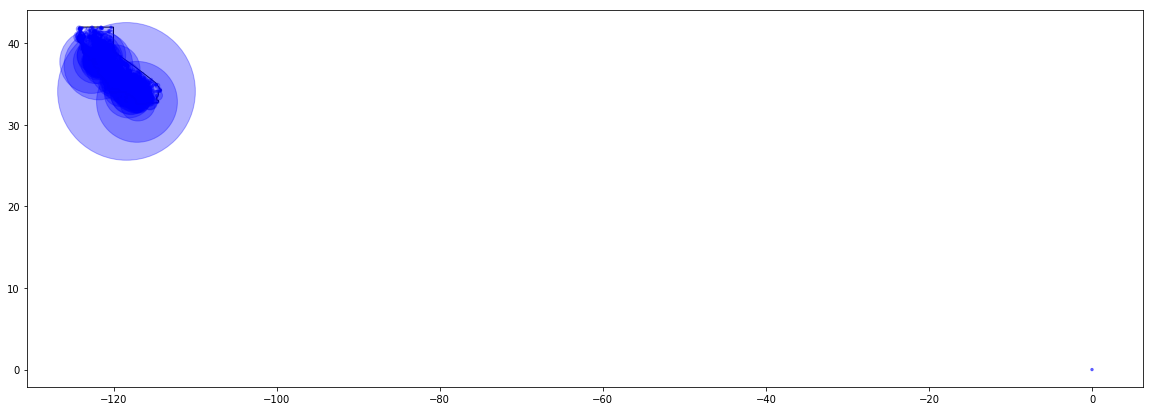

In [21]:
state = 'CA'

states = geopandas.read_file('../data/cb_2017_us_state_5m/cb_2017_us_state_5m.shp')

ax = states[states.STUSPS==state].plot(color='white', edgecolor='black', figsize=(20,20))

sdf = gdf[gdf.state==state]
print(len(sdf))

sdf.plot(ax=ax, color='blue', markersize=sdf['population'] / 200, alpha=0.3)
plt.show()

In [36]:
rows = WOFLocality.query.filter(WOFLocality.country_iso=='US').all()
id_row = {i: row for i, row in enumerate(rows)}

In [37]:
data = [[r.longitude, r.latitude] for r in rows]

In [38]:
idx = cKDTree(data)

In [39]:
len(idx.query_pairs(0.1))

202066

In [40]:
dupes = set()
for id1, id2 in tqdm(idx.query_pairs(0.1)):
    r1 = id_row[id1]
    r2 = id_row[id2]
    if r1.name == r2.name:
        if r1.completeness < r2.completeness:
            dupes.add(r1.wof_id)
        else:
            dupes.add(r2.wof_id)

100%|██████████| 202066/202066 [00:00<00:00, 269849.82it/s]


In [42]:
len(dupes)

815